In [1]:
import pickle
import zipfile
from google.colab import drive
drive.mount('/content/drive')

# update path to import from Drive
import sys
sys.path.append('content/drive/MyDrive')

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import time
from time import sleep
from tqdm import tqdm
import os

seed = 42
torch.manual_seed(seed)

device = 'cuda:0' # "cpu" 

use_ellipses = False

Mounted at /content/drive


In [2]:
folder_path = './'
if use_ellipses:
    data_path = folder_path + 'FFPN-Ellipse-TrainingData-0.015IndividualNoise.pkl'
else:
    data_path = folder_path + 'FFPN-Lodopab-TrainingData-0.015IndividualNoise.pkl'

if os.path.isfile(data_path):
    print("FFPN data .pkl file already exists.")
else:
    print("Extracting data from .pkl file.")
    if use_ellipses:
        with zipfile.ZipFile('/content/drive/MyDrive/FixedPointNetworks/FFPN-Ellipse-TrainingData-IndividualNoise.zip', 'r') as zip_ref:
            zip_ref.extractall('./')
    else:
        with zipfile.ZipFile('/content/drive/MyDrive/FixedPointNetworks/FFPN-Lodopab-TrainingData-IndividualNoise.zip', 'r') as zip_ref:
            zip_ref.extractall('./')        
    print("Extraction complete.")

    sys.path.append('content/drive/MyDrive/FixedPointNetworks')
    sys.path.insert(0,'/content/drive/MyDrive/FixedPointNetworks')  

state = torch.load(data_path)
A = state['A'].to(device)
u_train = state['u_true_train']
u_test = state['u_true_test']
data_obs_train = state['data_obs_train']
data_obs_test = state['data_obs_test']

Extracting data from .pkl file.
Extraction complete.


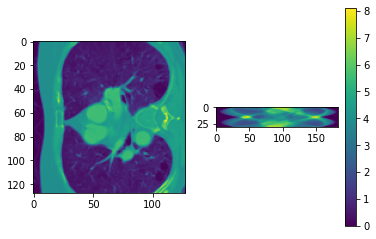

In [3]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(u_train[0,0,:,:])
plt.subplot(1,2,2)
plt.imshow(data_obs_train[0,0,:,:])
plt.colorbar()

In [4]:
# Create training datasets
batch_size  = 15
data_train  = TensorDataset(u_train, data_obs_train)
data_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
n_batches   = int(len(data_loader.dataset)/batch_size)
# Info about the dataset
print()
print(f'u_train.min(): {u_train.min()}')
print(f'u_train.max(): {u_train.max()}')
print("data_obs_train.shape = ", data_obs_train.shape)
print('n_batches = ', n_batches)
#print()*7410


u_train.min(): 0.0
u_train.max(): 1.0
data_obs_train.shape =  torch.Size([20000, 1, 30, 183])
n_batches =  1333


In [5]:
class TVM_Net(nn.Module):
    def __init__(self, A, lambd=0.1, alpha=0.1, beta=0.1, eps=1.0):
        super().__init__()
        self.A = A
        self.At = A.t() 
        self.lambd = lambd
        self.alpha = alpha
        self.beta = beta
        self.shrink = torch.nn.Softshrink(lambd=lambd)
        self.eps = eps

    def name(self) -> str:
        return "TVM_Net"

    def device(self):
        return "cuda:0" #next(self.parameters()).data.device

    def box_proj(self, u):
        return torch.clamp(u, min=0.0, max=1.0)
    
    def D(self, u):  
        u = u.view(128, 128, u.shape[-1])
        Dux = torch.roll(u, 1, 0) - u
        Dux = Dux.view(128 ** 2, u.shape[-1])
        Duy = torch.roll(u, 1, 1) - u
        Duy = Duy.view(128 ** 2, u.shape[-1])
        Du  = torch.cat((Dux, Duy), 0)
        return Du

    def Dt(self, p): 
        p    = p.view(256, 128, p.shape[1])
        px   = p[0:128, :, :]
        Dtpx = torch.roll(px, -1, 0) - px
        Dtpx = Dtpx.view(128 ** 2, p.shape[2])

        py   = p[128:256, :, :]
        Dtpy = torch.roll(py, -1, 1) - py
        Dtpy = Dtpy.view(128 ** 2, p.shape[2])
        Dtp  = Dtpx + Dtpy
        return Dtp        

    def ball_proj(self, w, d, eps):
        ''' Project w onto the ball B(d, eps)
        ''' 
        dist = torch.norm(w - d, dim=0)
        scale = torch.min(torch.ones(dist.shape, device=d.device), self.eps/dist)
        proj = d + scale * (w - d)



        #dist = torch.norm(w - d, dim=0) 
        #out_ball = dist > eps  
        #proj = w.clone() 
        #proj[:, out_ball] = d[:, out_ball] + (w[:, out_ball] - d[:, out_ball]) / dist[out_ball]
        return proj

    def forward(self, d, tol=1.0e-3, max_depth=12, 
                depth_warning=False):
      
        self.depth = 0.0

        # Initialize sequences 
        d    = d.view(d.size()[0],-1).to(self.device()) 
        d    = d.permute(1,0)         
        uk   = torch.zeros((128 ** 2, d.size()[1]), device=self.device())
        pk   = self.D(uk) 
        wk   = torch.matmul(self.A, uk)  
        nuk1 = torch.zeros(pk.size(), device=self.device())
        nuk2 = torch.zeros(d.size(), device=self.device())   

        for _ in range(max_depth):

            # TVM updates
            res1 = self.Dt(nuk1 + self.alpha * (self.D(uk) - pk))
            Auk  = torch.matmul(self.A, uk)
            res2 = torch.matmul(self.At, nuk2 + self.alpha * (Auk - wk))
            rk   = self.beta * (res1 + res2)
            uk   = self.box_proj(uk - rk)
            
            res  = self.lambd * (nuk1 + self.alpha * (self.D(uk)-pk))
            pk   = self.shrink(pk + res)

            Auk  = torch.matmul(self.A, uk)
            res  = self.lambd * (nuk2 + self.alpha * (Auk - wk))
            wk   = self.ball_proj(wk + res, d, self.eps)
 
            nuk1 = nuk1 + self.alpha * (self.D(uk) - pk)
            nuk2 = nuk2 + self.alpha * (torch.matmul(self.A, uk) - wk)

        self.depth = max_depth
        if self.depth >= max_depth and depth_warning:
            print("\nWarning: Max Depth Reached - Break Forward Loop\n")

        uk = uk.permute(1,0)        
        return uk.view(uk.shape[0], 1, 128, 128)

Setup Network

In [6]:
Phi = TVM_Net(A.to(device))
Phi = Phi.to(device)
print(Phi)
pytorch_total_params = sum(p.numel() for p in Phi.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {pytorch_total_params}')

max_epochs = 2000 
max_depth  = 250 
criterion  = torch.nn.MSELoss()  
fmt        = '[{:2d}/{:2d}]: train_loss = {:7.3e} | ' 
fmt       += 'depth = {:5.1f} | lr = {:5.1e} | time = {:4.1f} sec'

TVM_Net(
  (shrink): Softshrink(0.1)
)
Number of trainable parameters: 0


Train the Network

In [ ]:
best_loss = 1.0e10 

for epoch in range(max_epochs): 
  sleep(0.5)  # slows progress bar so it won't print on multiple lines
  tot = len(data_loader)
  loss_ave = 0.0
  start_time_epoch = time.time() 
  with tqdm(total=tot, unit=" batch", leave=False, ascii=True) as tepoch:      
    for idx, (u_batch, d) in enumerate(data_loader): 
        u_batch    = u_batch.to(device) 
        batch_size = u_batch.shape[0]
        train_batch_size = d.shape[0] # re-define if batch size changes
        u = Phi(d.to(device), max_depth=max_depth) # add snippet for hiding
        output = criterion(u, u_batch)
        train_loss = output.detach().cpu().numpy()
        loss_ave += train_loss * train_batch_size
 
        if idx%2 == 0:
            # compute test image 
            Phi.eval()
            u_test_approx = Phi(data_obs_test[0:1,:,:,:], max_depth=max_depth)

            plt.figure()
            plt.subplot(2,2,1)
            plt.imshow(u_batch[0,0,:,:].cpu(), vmin=0, vmax=1)
            plt.title('u true train')
            plt.subplot(2,2,2)
            plt.imshow(u[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
            plt.title('u approx train')
            plt.subplot(2,2,3)
            plt.imshow(u_test[0,0,:,:].cpu(), vmin=0, vmax=1)
            plt.title('u true test')
            plt.subplot(2,2,4)
            plt.imshow(u_test_approx[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
            plt.title('u approx test')
            plt.show() 
            Phi.train() 

        tepoch.update(1)
        tepoch.set_postfix(train_loss="{:5.2e}".format(train_loss),
                            depth="{:5.1f}".format(Phi.depth))
    

  loss_ave = loss_ave/len(data_loader.dataset)
  end_time_epoch = time.time()
  time_epoch = end_time_epoch - start_time_epoch
  #lr_scheduler.step()
  print(fmt.format(epoch+1, max_epochs, loss_ave, Phi.depth, 
                   0.0,
                   time_epoch))

In [8]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

n_samples = u_test.shape[0]

data_test     = TensorDataset(u_test, data_obs_test)
test_data_loader     = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=True)


def compute_avg_SSIM_PSNR(u_true, u_gen, n_mesh, data_range):
    # assumes images are size n_samples x n_features**2 and are detached
    n_samples = u_true.shape[0]
    u_true = u_true.reshape(n_samples, n_mesh, n_mesh).cpu().numpy()
    u_gen  = u_gen.reshape(n_samples, n_mesh, n_mesh).cpu().numpy()
    ssim_val = 0
    psnr_val = 0
    for j in range(n_samples):
        ssim_val = ssim_val + ssim(u_true[j,:,:], u_gen[j,:,:], data_range=data_range)
        psnr_val = psnr_val + psnr(u_true[j,:,:], u_gen[j,:,:], data_range=data_range)
    return ssim_val/n_samples, psnr_val/n_samples

In [ ]:

test_loss_ave = 0
test_PSNR_ave = 0
test_SSIM_ave = 0
with torch.no_grad():
    for idx, (u_batch, d) in enumerate(test_data_loader): 

        u_batch    = u_batch.to(device) 
        batch_size = u_batch.shape[0]
        temp       = u_batch.view(batch_size, -1)
        temp       = temp.permute(1,0)        
        test_batch_size = d.shape[0] # re-define if batch size changes
        Phi.eval()
        u = Phi(d, max_depth=max_depth) # add snippet for hiding
        output = criterion(u, u_batch)
        test_loss = output.detach().cpu().numpy()
        test_SSIM, test_PSNR = compute_avg_SSIM_PSNR(u_batch, u, 128, 1)
        test_PSNR_ave += test_PSNR * test_batch_size
        test_loss_ave += test_loss * test_batch_size
        test_SSIM_ave += test_SSIM * test_batch_size

        print('test_PSNR = {:7.3e}'.format(test_PSNR))
        print('test_SSIM = {:7.3e}'.format(test_SSIM))
        print('test_loss = {:7.3e}'.format(test_loss))
        if idx%1 == 0:
            # compute test image 
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(u_batch[0,0,:,:].cpu(), vmin=0, vmax=1)
            plt.title('u true')
            plt.subplot(1,2,2)
            plt.imshow(u[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
            plt.title('u approx')
            plt.show()  

print('\n\nSUMMARY')
print('test_loss_ave =  {:7.3e}'.format(test_loss_ave / len(data_loader.dataset)))
print('test_PSNR_ave =  {:7.3e}'.format(test_PSNR_ave / len(data_loader.dataset)))
print('test_SSIM_ave =  {:7.3e}'.format(test_SSIM_ave / len(data_loader.dataset)))

In [ ]:
if use_ellipses:
    ind_val = 0
else:
    ind_val = 1000

u = Phi(data_obs_test[ind_val,:,:,:], max_depth=max_depth).view(128,128)
u_true = u_test[ind_val,0,:,:]
def string_ind(index):
    if index < 10:
        return '000' + str(index)
    elif index < 100:
        return '00' + str(index)
    elif index < 1000:
        return '0' + str(index)
    else:
        return str(index)

cmap = 'gray'
fig = plt.figure()
plt.imshow(np.rot90(u.detach().cpu().numpy()),cmap=cmap, vmin=0, vmax=1)
plt.axis('off')

data_type = 'Ellipse' if use_ellipses else 'Lodopab'

save_loc = './drive/MyDrive/FixedPointNetworks/Learned_Feasibility_' + data_type + '_TVM_ind_' + string_ind(ind_val) + '.pdf'
plt.savefig(save_loc,bbox_inches='tight')
plt.show()

print("SSIM: ", compute_avg_SSIM_PSNR(u_true.view(1,128,128), u.view(1,128,128).detach(), 128, 1))

############
# TRUE
###########

cmap = 'gray'
fig = plt.figure()
plt.imshow(np.rot90(u_true.detach().cpu().numpy()),cmap=cmap, vmin=0, vmax=1)
plt.axis('off')


save_loc = './drive/MyDrive/FixedPointNetworks/Learned_Feasibility_' + data_type + '_GT_ind_' + string_ind(ind_val) + '.pdf'
plt.savefig(save_loc,bbox_inches='tight')
plt.show()